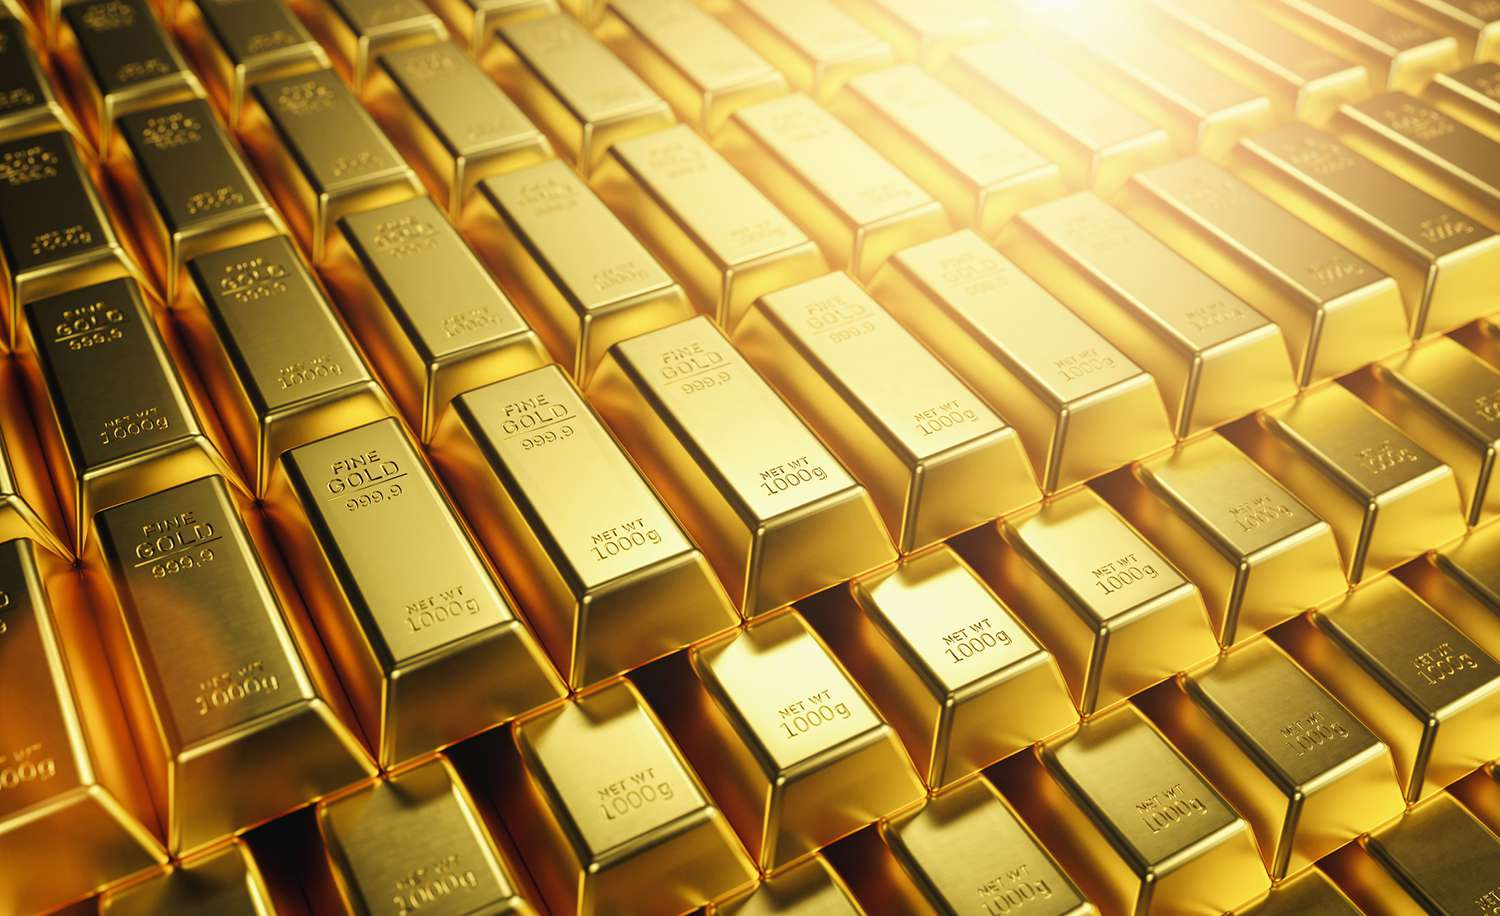

__In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2013 to 2023).__

### Let's get started:

# Step 1: Importing Libraries

In [1]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression
# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np
# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt



# Step 2: Reading Dataset

In [153]:
df = pd.read_csv('GLD-daily.csv')

# Step 3: Dataset Overview

In [154]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-31,114.610001,117.129997,114.459999,116.120003,116.120003,12835900
1,2014-01-02,117.930000,118.730003,117.750000,118.000000,118.000000,7551000
2,2014-01-03,118.639999,119.620003,118.589996,119.290001,119.290001,5874400
3,2014-01-06,119.760002,120.389999,117.110001,119.500000,119.500000,10106500
4,2014-01-07,118.459999,118.919998,118.129997,118.820000,118.820000,6433700
...,...,...,...,...,...,...,...
2512,2023-12-22,191.600006,191.880005,190.070007,190.270004,190.270004,7175400
2513,2023-12-26,190.970001,191.740005,190.399994,191.720001,191.720001,4502700
2514,2023-12-27,191.770004,193.179993,191.539993,192.589996,192.589996,5813300
2515,2023-12-28,192.339996,192.889999,191.440002,191.470001,191.470001,6171500


__Dataset Basic Information:__

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2517 non-null   object 
 1   Open       2517 non-null   float64
 2   High       2517 non-null   float64
 3   Low        2517 non-null   float64
 4   Close      2517 non-null   float64
 5   Adj Close  2517 non-null   float64
 6   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Adj Close and Volume features to predict Price, we will drop these two features:__

In [157]:
df.drop(['Adj Close', 'Volume'], axis=1, inplace=True)

## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [158]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [159]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [160]:
df.head()

,Date,Open,High,Low,Close
0,2013-12-31,114.610001,117.129997,114.459999,116.120003
1,2014-01-02,117.930000,118.730003,117.750000,118.000000
2,2014-01-03,118.639999,119.620003,118.589996,119.290001
3,2014-01-06,119.760002,120.389999,117.110001,119.500000
4,2014-01-07,118.459999,118.919998,118.129997,118.820000


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [161]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [162]:
df.isnull().sum().sum()

0

# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [163]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Gold ETF Prices",
                  title={'text': "Gold ETF Price Series", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='white')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

# Define explanatory variables

An explanatory variable is a variable that is manipulated to determine the value of the Gold ETF price the next day. Simply, they are the features which we want to use to predict the Gold ETF price.
The explanatory variables in this strategy are the moving average for past 3 days and 9 days. We drop the NaN values using dropna() function and store the feature variables in X.

Similarly, the dependent variable depends on the values of the explanatory variables. Simply put, it is the Gold ETF price which we are trying to predict. We store the Gold ETF price in y.


In [164]:
Df = df.copy()

# Convert 'Date' to datetime and set as index
Df['Date'] = pd.to_datetime(Df['Date'])
Df.set_index('Date', inplace=True)

# Define explanatory variables
Df['S_5'] = Df['Close'].rolling(window=3).mean()
Df['S_10'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_5', 'S_10']]

# Define dependent variable
y = Df['next_day_price']

In [165]:
Df

,Open,High,Low,Close,S_5,S_10,next_day_price
Date,,,,,,,
2014-01-13,120.269997,121.040001,120.199997,121.019997,119.913333,118.843334,119.889999
2014-01-14,120.540001,121.059998,119.720001,119.889999,120.389999,119.262222,119.660004
2014-01-15,119.190002,119.809998,119.110001,119.660004,120.190000,119.446667,119.790001
2014-01-16,119.839996,119.959999,119.570000,119.790001,119.780001,119.502223,120.930000
2014-01-17,120.349998,121.019997,120.199997,120.930000,120.126668,119.661112,119.699997
...,...,...,...,...,...,...,...
2023-12-21,189.210007,189.619995,188.750000,189.429993,188.886668,187.216668,190.270004
2023-12-22,191.600006,191.880005,190.070007,190.270004,189.266668,187.958891,191.720001
2023-12-26,190.970001,191.740005,190.399994,191.720001,190.473333,188.873335,192.589996


# Split the data into train and test dataset

In this step, we split the predictors and output data into train and test data. The training data is used to create the linear regression model, by pairing the input with expected output.

The test data is used to estimate how well the model has been trained

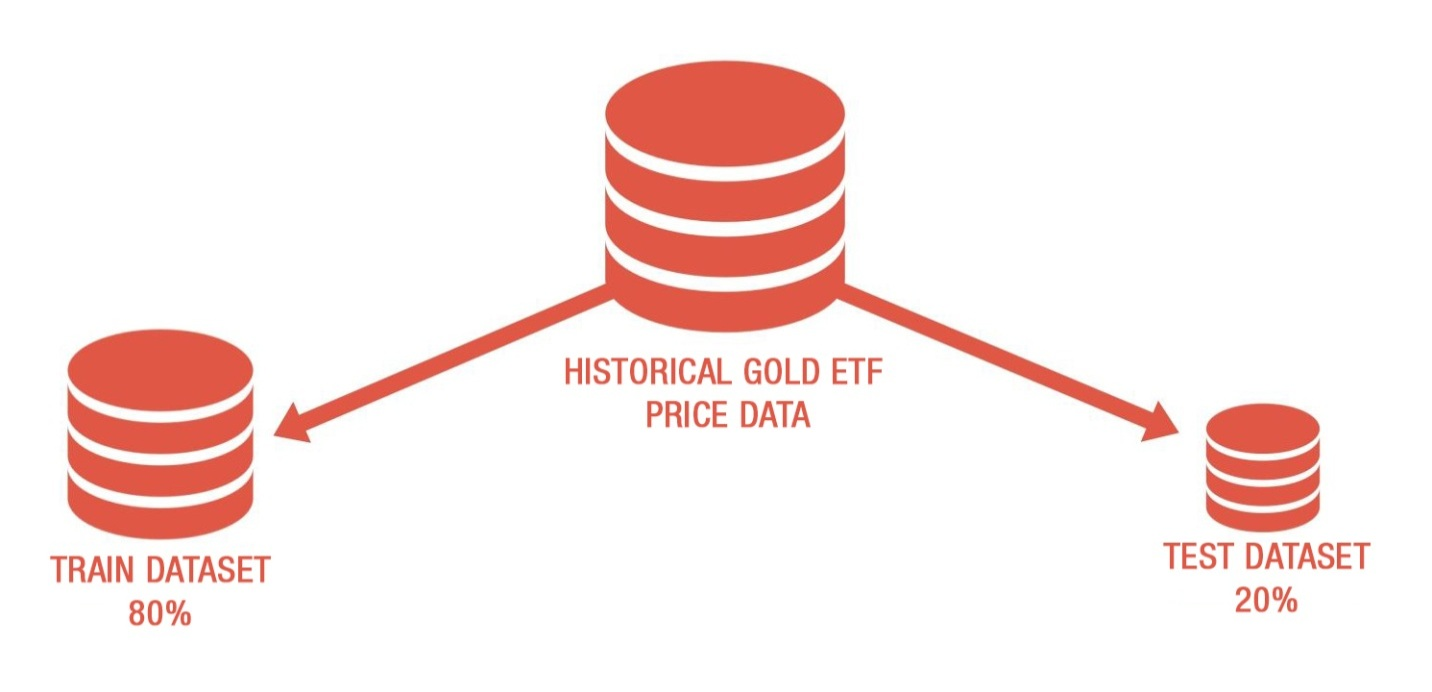

1. First 80% of the data is used for training and remaining data for testing
2. X_train & y_train are training dataset
3. X_test & y_test are test dataset

In [166]:
# Split the data into train and test datasets
t = .8
t = int(t * len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]


# Create a linear regression model

We will now create a linear regression model. But, what is linear regression?

If we try to capture a mathematical relationship between ‘x’ and ‘y’ variables that “best” explains the observed values of ‘y’ in terms of observed values of ‘x’ by fitting a line through a scatter plots then such an equation between x and y is called linear regression analysis.

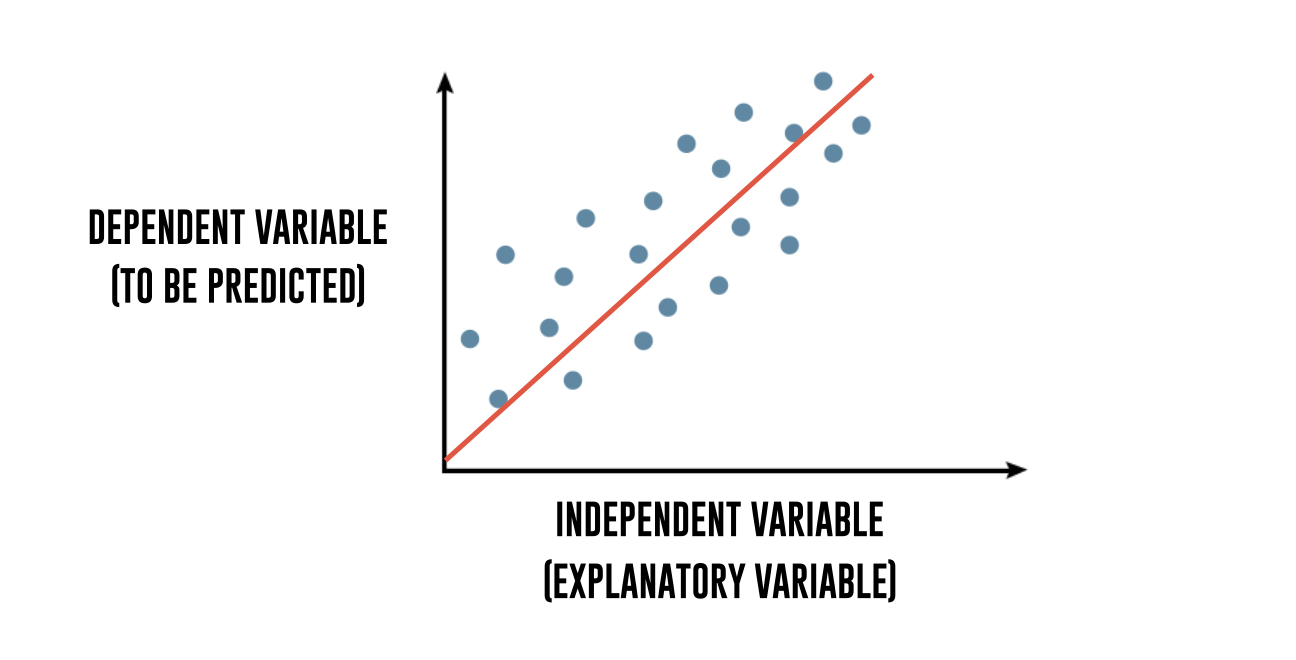

To break it down further, regression explains the variation in a dependent variable in terms of independent variables. The dependent variable - ‘y’ is the variable that you want to predict. The independent variables - ‘x’ are the explanatory variables that you use to predict the dependent variable. The following regression equation describes that relation:

Y = m1 * X1 + m2 * X2 + C

Gold ETF price = m1 * 5 days moving average + m2 * 10 days moving average + c

Then we use the fit method to fit the independent and dependent variables (x’s and y’s) to generate coefficient and constant for regression.

In [167]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 5 Days Moving Average (x1) \
+ %.2f * 10 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.17 * 5 Days Moving Average (x1) + -0.17 * 10 Days Moving Average (x2) + 0.22 (constant)


# Predict the Gold ETF prices

Now, it’s time to check if the model works in the test dataset. We predict the Gold ETF prices using the linear model created using the train dataset. The predict method finds the Gold ETF price (y) for the given explanatory variable X.

In [170]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Close'])

# Plotting the results using Plotly
fig = go.Figure()

# Add traces for predicted and actual prices
fig.add_trace(go.Scatter(x=predicted_price.index, y=predicted_price['Close'], mode='lines', name='Predicted Price'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual Price'))

# Update layout
fig.update_layout(
    title="Predicted vs Actual Gold ETF Price",
    xaxis_title="Date",
    yaxis_title="Gold ETF Price",
    legend_title="Legend",
    xaxis=dict(
        tickformat='%Y-%m-%d',
        tickangle=45,
        dtick="M12",  # Show ticks every 12 months (1 year)
    ),
    width=1000,  # Increase the width of the plot
    height=600,  # Increase the height of the plot
    plot_bgcolor='white',  # Set the plot background color to white
    paper_bgcolor='white'  # Set the paper background color to white
)

fig.show()

The graph shows the predicted and actual price of the Gold ETF.

Now, let’s compute the goodness of the fit using the score() function.

In [171]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

96.34

As it can be seen, the R-squared of the model is 96.34%. R-squared is always between 0 and 100%. A score close to 100% indicates that the model explains the Gold ETF prices well.

# Plotting cumulative returns

Let’s calculate the cumulative returns of this strategy to analyse its performance.

1. The steps to calculate the cumulative returns are as follows:
2. Generate daily percentage change of gold price
3. Create a buy trading signal represented by “1” when the next day’s predicted price is more than the current day predicted price. No position is taken otherwise
4. Calculate the strategy returns by multiplying the daily percentage change with the trading signal.
5. Finally, we will plot the cumulative returns graph

In [172]:
# Prepare gold DataFrame
gold = pd.DataFrame()
gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)
gold['signal'] = np.where(gold['predicted_price_next_day'].shift(1) < gold['predicted_price_next_day'], 1, 0)
gold['strategy_returns'] = gold['signal'] * gold['gold_returns']


In [173]:
# Calculate cumulative returns
gold['cumulative_returns'] = (gold['strategy_returns'] + 1).cumprod()

# Plotting the results using Plotly
fig = go.Figure()

# Add trace for cumulative returns
fig.add_trace(go.Scatter(x=gold.index, y=gold['cumulative_returns'], mode='lines', name='Cumulative Returns', line=dict(color='green')))

# Update layout
fig.update_layout(
    title="Cumulative Returns",
    xaxis_title="Date",
    yaxis_title="Cumulative Returns",
    legend_title="Legend",
    xaxis=dict(
        tickformat='%Y-%m-%d',
        tickangle=45,
        dtick="M12",  # Show ticks every 12 months (1 year)
    ),
    width=1000,  # Increase the width of the plot
    height=600,  # Increase the height of the plot
    plot_bgcolor='white',  # Set the plot background color to white
    paper_bgcolor='white'  # Set the paper background color to white
)

fig.show()

In [174]:
gold.head(10)

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,strategy_returns,cumulative_returns
Date,,,,,,,
2021-12-30,169.800003,169.091820,170.960007,0.006832,0,0.000000,1.000000
2021-12-31,170.960007,169.934928,168.330002,-0.015384,1,-0.015384,0.984616
2022-01-03,168.330002,169.810716,169.570007,0.007367,0,0.000000,0.984616
2022-01-04,169.570007,169.673739,169.059998,-0.003008,0,-0.000000,0.984616
2022-01-05,169.059998,168.926237,166.990005,-0.012244,0,-0.000000,0.984616
2022-01-06,166.990005,168.442160,167.750000,0.004551,0,0.000000,0.984616
2022-01-07,167.750000,167.764738,168.259995,0.003040,0,0.000000,0.984616
2022-01-10,168.259995,167.460777,170.289993,0.012065,0,0.000000,0.984616
2022-01-11,170.289993,168.712135,170.740005,0.002643,1,0.002643,0.987218


We will also calculate the Sharpe ratio.

In [175]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 0.65'

# How to use this model to predict daily moves?

You can use the following code to predict the gold prices and give a trading signal whether we should buy GLD or take no position

In [176]:
data = df.copy()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [179]:
data['S_5'] = data['Close'].rolling(window=5).mean()
data['S_10'] = data['Close'].rolling(window=10).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_5', 'S_10']])
data = data.round(2)  # Round all columns to two decimal places
data['signal'] = np.where(data['predicted_gold_price'].shift(1) < data['predicted_gold_price'], "Buy", "No Position")
data.tail(3)


,Open,High,Low,Close,S_5,S_10,predicted_gold_price,signal
Date,,,,,,,,
2023-12-27,191.77,193.18,191.54,192.59,190.42,189.25,190.57,Buy
2023-12-28,192.34,192.89,191.44,191.47,191.10,189.63,191.30,Buy
2023-12-29,190.99,191.64,190.74,191.17,191.44,189.87,191.66,Buy
